In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio


# POUR LA MORPHO
from skimage.segmentation import watershed 
from skimage.feature import peak_local_max



In [2]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES: 
colaboratory=False #mettre True si vous utilisez google colab
notebook=False   # mettre Trus si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    





In [3]:
#%% fonction pour voir une image




def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a /Applications/GIMP.app '
        endphrase=' &' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp -a '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    if titre!='':
        titre='_'+titre+'_'
    nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

#si on est dans un notebook (y compris dans colab), on utilise bokeh pour visualiser

usebokeh= colaboratory or notebook
if usebokeh:
    def normalise_image_pour_bokeh(X,normalise,MINI,MAXI):
        imt=np.copy(X.copy())
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
        imt*=255
      
        sortie=np.empty((*imt.shape,4),dtype=np.uint8)
        for k in range(3):
            sortie[:,:,k]=imt
        sortie[:,:,3]=255
        return sortie
    def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
        
        img=normalise_image_pour_bokeh(np.flipud(im),normalise,MINI,MAXI)# np.flipud(np.fliplr(im)))
        p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],title=titre)
        p.x_range.range_padding = p.y_range.range_padding = 0

        # must give a vector of images
        p.image_rgba(image=[img], x=0,y=0, dw=im.shape[1], dh=im.shape[0])
        showbokeh(p)

  


In [4]:
#FONCTION viewimage universelle
import tempfile
import numpy as np
import IPython
import matplotlib.pyplot as plt
def viewimage(im, normalize=True,titre='',displayfilename=False):
    imin=im.copy().astype(np.float32)
    if normalize:
        imin-=imin.min()
    if imin.max()>0:
        imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255


    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

In [36]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out    

def degrade_image(im,br): 
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py): 
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape 
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))
    
    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]
    
    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser 
# la fonctionnelle E2 par descente de gradient nous avons choisi 
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive
     

def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """
     
    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=np.vectorize(complex)(np.zeros((sy,sx)))
    denom=np.vectorize(complex)(np.zeros((sy,sx)))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1                  # Noyau du dérivateur, on convolue avec des images de même taille
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I): 
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        #print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax): 
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman 
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))
    
    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P                

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2 
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


In [6]:
#%% lire une image

im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())



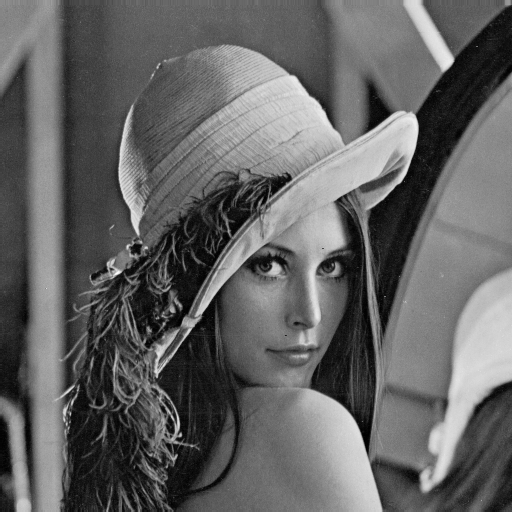

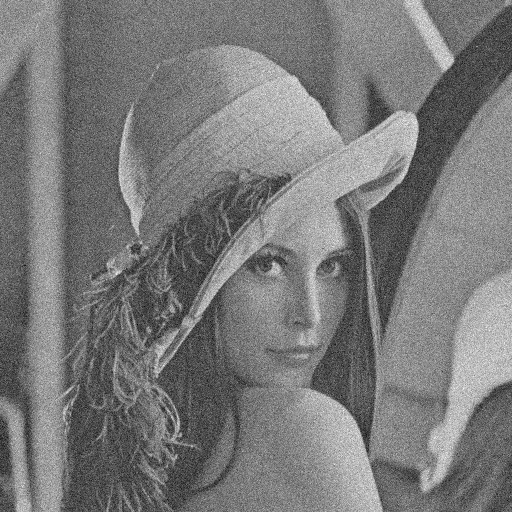

In [7]:
#%%

# voir l'image
viewimage(im,titre='ORIGINALE')
#degrader une image

imb=degrade_image(im,25)

# voir l'image bruitée 
viewimage(imb,titre='BRUITEE')



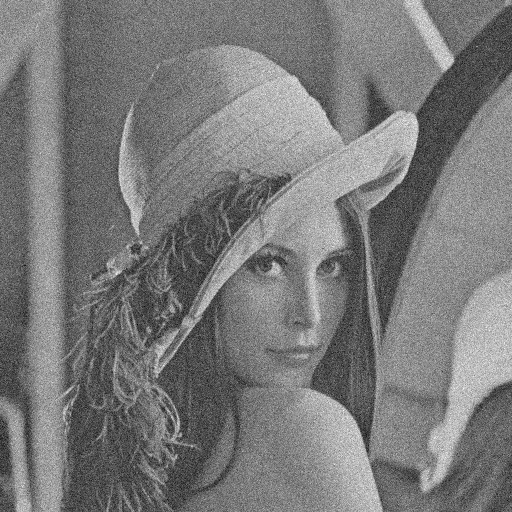

In [8]:
#%% restauration quadratique : exemple
lamb=0.001              # = 0.1
restau=minimisation_quadratique(imb,lamb)
viewimage(restau,titre='RESTQUAD_LAMB='+str(lamb))



In [9]:
#%% COMPARAISON des methodes
# vous pouvez vous inspirer de ce qui suit pour trouver les meilleurs 
# parametres de regularisation 

errq=[]
errvt=[]
erreur=[]
vk=np.arange(0,0.25,0.01);
for k in vk: 
    #print (k)
    #restq=minimisation_quadratique(imb,10^(k));
    #errq.append[]=norm2(restq-myim);
    #restva=vartotale_Chambolle(imb,10**(k));
    restq=minimisation_quadratique(imb,10**(k))
    erreur.append(norm2(im-restq))
    #viewimage(restq)
    #errvt.append(norm2(restva-myim));
    


#plt.plot(10**vk,errvt);
erreur




[5323.645198901772,
 5317.111059865417,
 5311.5738280636615,
 5307.028391254285,
 5303.469044651027,
 5300.8895098590365,
 5299.28295503575,
 5298.6420161824,
 5298.958819465439,
 5300.225004462147,
 5302.431748220558,
 5305.569790020991,
 5309.629456724415,
 5314.600688592059,
 5320.473065460697,
 5327.235833159207,
 5334.877930053937,
 5343.38801361334,
 5352.754486885961,
 5362.965524790307,
 5374.009100120111,
 5385.873009174088,
 5398.544896925337,
 5412.012281651919,
 5426.262578956851]

# Débruitage par régularisation quadratique


Question 1:

On peut tester plusieurs valeurs de lambda avec la fonction resoud_quad_fourier, et voire l'image qui minimise l'énergie.


Question 2:

On remarque que pour $\lambda$ très petit (de l'ordre de 0.001 par exemple), on retrouve une image fortement bruité, c'est parce que le terme d'attache aux données $\|u-v\|$ est trop important.

Au contraire pour un lambda trop grand ($\lambda = 10 $ par exemple), l'algorithme trouve une solution qui minimise avant le gradiant au carré de la solution $\lambda \| \nabla u\|^2 $, on trouve ainsi une image avec des frécquences trop faibles  et qui apparait flou.

In [10]:
def dichotomie(lambda_inf, lambda_sup):
    lambda_mean = (lambda_inf+ lambda_sup)/2
    restq=minimisation_quadratique(imb,lambda_mean)
    erreur = norm2(imb-im)      # Image parfaite moins l'image dégradé
    erreur1 = norm2(imb-restq)
    nb_iter = 0
    while abs(erreur1 - erreur)>0.0001:
        nb_iter +=1
        erreur_inf = norm2(minimisation_quadratique(imb,lambda_inf)-imb)
        erreur_sup = norm2(minimisation_quadratique(imb,lambda_sup)-imb)
        if abs(erreur_inf-erreur)< abs(erreur_sup-erreur):
            lambda_sup = (lambda_inf+ lambda_sup)/2
            erreur1 = erreur_inf
        else :
            lambda_inf = (lambda_inf+ lambda_sup)/2
            erreur1 = erreur_sup
    print(nb_iter)
    return lambda_inf

dichotomie(0.1,6)



25


3.171085065603256

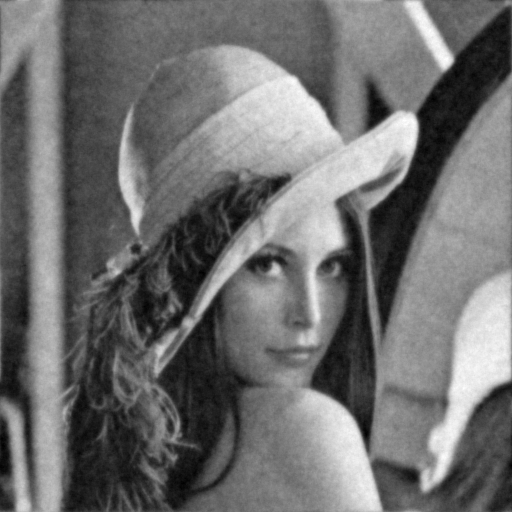

In [11]:
lamb=  3.1675036847591396            # = 0.1
restau=minimisation_quadratique(imb,lamb)
viewimage(restau,titre='RESTQUAD_LAMB='+str(lamb))

Question 3:

On trouve $\lambda = 3.1675036847591396$ 

1.1800000000000002


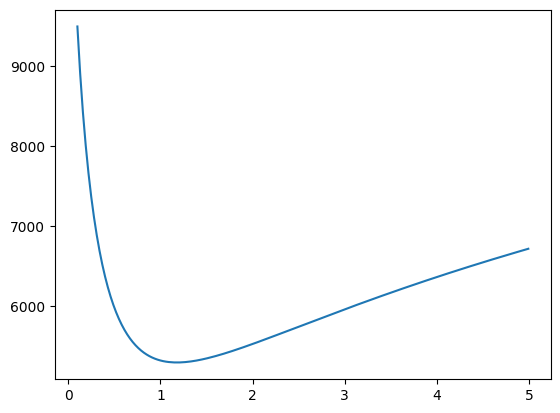

In [12]:
"""def dichotomie2(lambda_inf, lambda_sup):
    lambda_mean = (lambda_inf+ lambda_sup)/2
    restq=minimisation_quadratique(imb,lambda_mean)
    erreur1 = norm2(imb-restq)
    nb_iter = 0
    erreur2 = norm2(minimisation_quadratique(imb,lambda_inf)-im)
    while abs(lambda_inf-lambda_sup)>0.000001:
        nb_iter +=1
        print(erreur1)
        erreur_inf = norm2(minimisation_quadratique(imb,lambda_inf)-im)
        erreur_sup = norm2(minimisation_quadratique(imb,lambda_sup)-im)
        if erreur_inf< erreur_sup:
            lambda_sup = (lambda_inf+ lambda_sup)/2
            erreur1 = erreur2
            erreur2 = erreur_inf   
        else :
            lambda_inf = (lambda_inf+ lambda_sup)/2
            erreur1 = erreur2
            erreur2 = erreur_sup
    print(nb_iter)
    return lambda_inf

dichotomie2(0.1,6)"""

errq=[]
errvt=[]
erreur = []
erreur_inf=8000
k_inf = 0.1
vk=np.arange(0.1,5,0.03);
for k in vk: 
    #print (k)
    restq=minimisation_quadratique(imb,k);
    #restva=vartotale_Chambolle(imb,10**(k));
    #restq=minimisation_quadratique(imb,10**(k))
    erreur1 = norm2((im-restq))
    if erreur1 < erreur_inf:
        erreur_inf = erreur1
        k_inf = k
    erreur.append(erreur1)
    #viewimage(restq)
   
    


plt.plot(vk,erreur);
print(k_inf)
#erreur



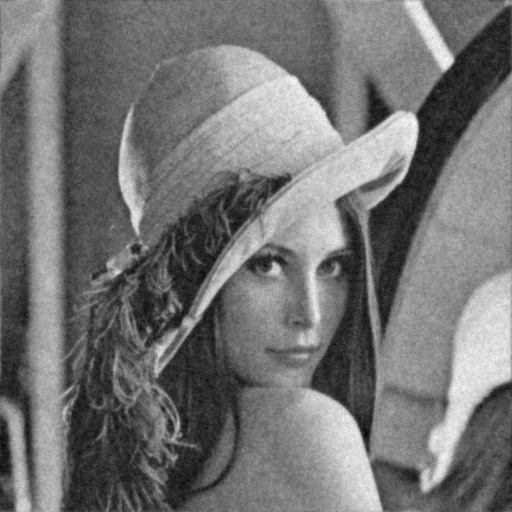

In [13]:
lamb= 1.18             # = 0.1
restau=minimisation_quadratique(imb,lamb)
viewimage(restau,titre='RESTQUAD_LAMB='+str(lamb))

Question 4:

On trouve $\lambda = 1.18$, en voulant simplement minimiser la distance entre l'image originalle et l'image retrouvée, on trouve un terme de régularisation plus faible que si on chercher $\lambda$ tel que l'image reconstruite soit à la même distance de l'image dégradée que ne l'est l'image parfaite.

# Débruitage par variation totale

question 2.1:

Pour le pas de 1, l'algorithme diverge. On remarque que l'on trouve des solutions différentes selon le pas utilisé.

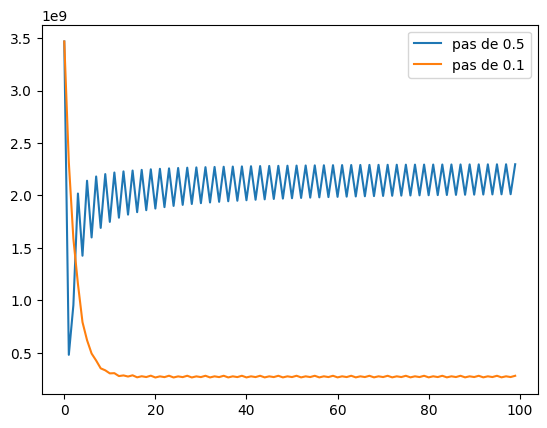

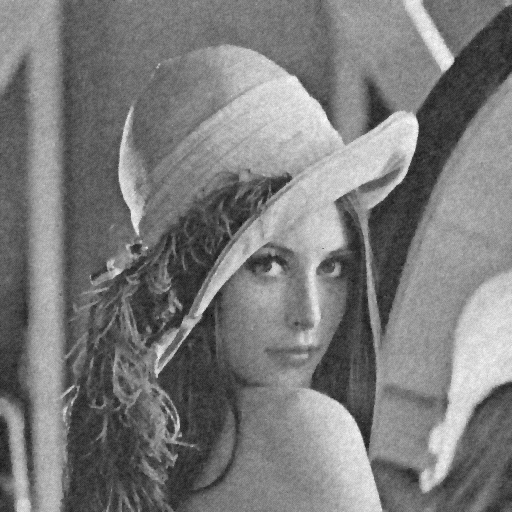

In [39]:
#%%
imb = degrade_image(im,25)
u1,en1=minimise_TV_gradient(imb, 40, 1, 100)
u05,en05=minimise_TV_gradient(imb, 40, 0.5, 100)
u01,en01=minimise_TV_gradient(imb, 40, 0.1, 100)
#u05inf,en05inf=minimise_TV_gradient(imb, 10, 0.5, 200)

plt.plot(en05,label="pas de 0.5")
#plt.plot(en1,label = "pas de 1")

plt.plot(en01, label="pas de 0.1")
plt.legend()
plt.show()

viewimage(u01,titre='RESTQUAD_LAMB='+str(lamb))

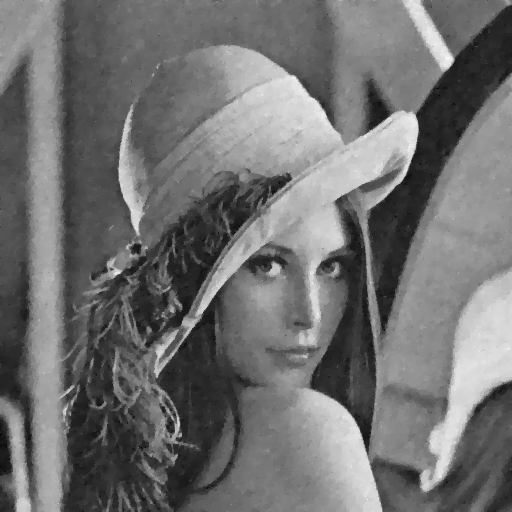

In [34]:
en = vartotale_Chambolle(imb,40,100)
viewimage(en)

Question 2.1)
On remarque que cette méthode est plus rapide que celle de la descente de gradient, et on obtient un résultat moins bruité.

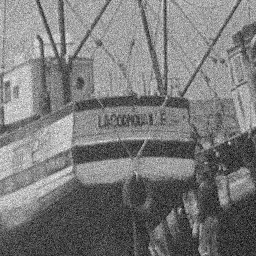

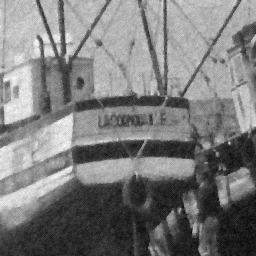

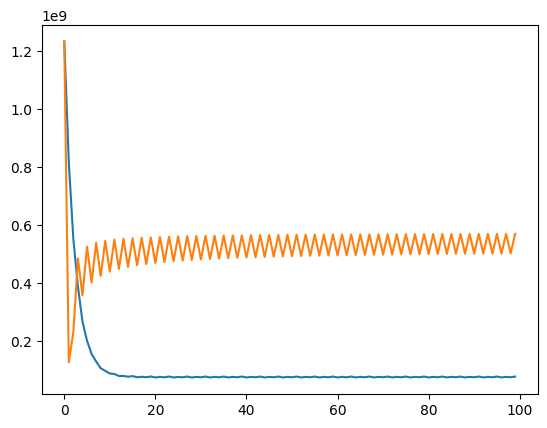

In [51]:
#%%
myim=imread('lacornou.tif')
imb=degrade_image(myim,25)
(u,energ)=minimise_TV_gradient(imb,40,0.1,100)   # pas = 0.1
(u2,energ2)=minimise_TV_gradient(imb,40,0.5,100)       # pas = 0.5
plt.plot(energ)
plt.plot(energ2)



viewimage(imb)
viewimage(u,titre="descente de gradient, pas de 0.1")




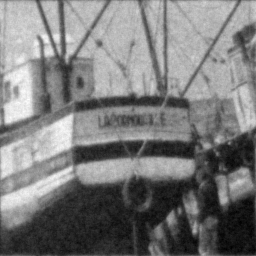

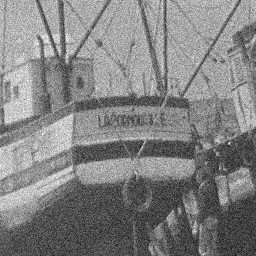

In [72]:
myim=imread('lacornou.tif')
imb=degrade_image(myim,25)
im = myim




lamb=  1.5         # = 0.1
restau=minimisation_quadratique(imb,lamb)
viewimage(restau,titre='RESTQUAD_LAMB='+str(lamb))

viewimage(imb)


Question 3:

Après avoir testé plusieurs lambda possible pour les deux méthodes, on obtient un meilleur résultat avec la méthode de descente de gradient.